C:\Users\Art\anaconda3\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


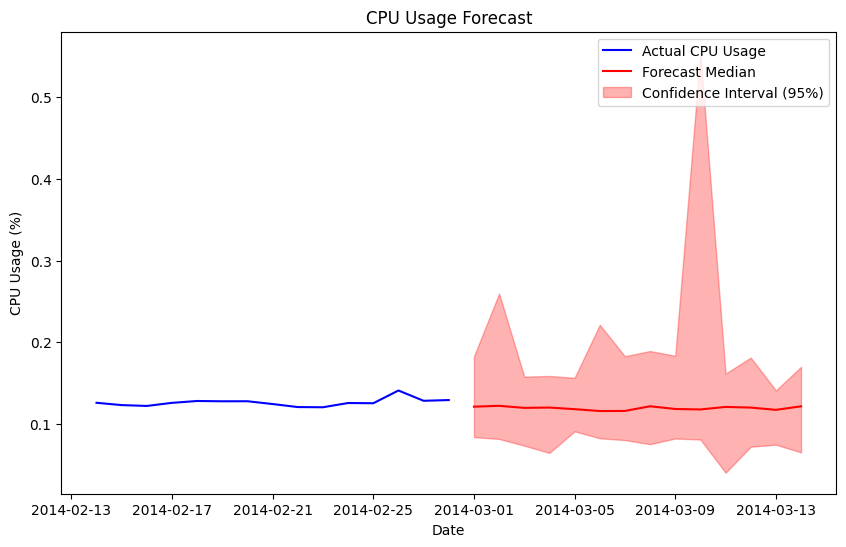

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast
from uni2ts.model.moirai import MoiraiModule

import torch
print(torch.cuda.is_available()) 

# Step 1: Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/refs/heads/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv', sep=',')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[['timestamp', 'value']]  # Keep relevant columns
df = df.set_index('timestamp')

# Resample to daily frequency (optional, depending on dataset)
df = df.resample('D').mean()

# Step 2: Convert dataset to a PandasDataset format required by Moirai
# Use a dummy item_id (e.g., '0') since the dataset doesn't have one
df['item_id'] = 0  # Adding a dummy column as item_id

# Convert the dataframe into the correct format for Moirai
ds = PandasDataset.from_long_dataframe(df, target='value', item_id='item_id')

# Step 3: Initialize the Moirai Model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),  # Load pretrained Moirai
    prediction_length=14,  # Forecasting 14 days ahead
    context_length=len(df),  # Use full historical data as context
    patch_size='auto',  # Auto-patch the input series
    num_samples=100,  # Generate 100 samples from the forecast distribution
    target_dim=1,  # We are predicting a single time series (CPU usage)
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,  # Dynamic features (if any)
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real  # Past dynamic features (if any)
)

# Step 4: Generate predictions
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)

# Convert the forecast results into a list
forecasts = list(forecasts)

# Step 5: Extract median and confidence intervals
# Define a function to extract the median and confidence intervals from the samples
def get_median_and_ci(forecasts, ci=0.95):
    forecast_samples = forecasts[0].samples  # Assume single time series
    median = np.median(forecast_samples, axis=0)
    lower_bound = np.percentile(forecast_samples, (1 - ci) / 2 * 100, axis=0)
    upper_bound = np.percentile(forecast_samples, (1 + ci) / 2 * 100, axis=0)
    return median, lower_bound, upper_bound

# Get the forecasted median and confidence intervals
forecast_median, forecast_lower, forecast_upper = get_median_and_ci(forecasts)

# Step 6: Create time index for forecasted data
forecast_index = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')

# Step 7: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[-50:], df['value'][-50:], label='Actual CPU Usage', color='blue')
plt.plot(forecast_index, forecast_median, label='Forecast Median', color='red')
plt.fill_between(forecast_index, forecast_lower, forecast_upper, color='red', alpha=0.3, label='Confidence Interval (95%)')
plt.title("CPU Usage Forecast")
plt.xlabel("Date")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()
